# Offline Replayer Evaluation V - Movielens
> Evaluating bandits offline with replay method on movielens dataset

- toc: true
- badges: true
- comments: true
- categories: [bandit, movie]
- image: 

## Environment setup

### Import libraries

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

### Set variables

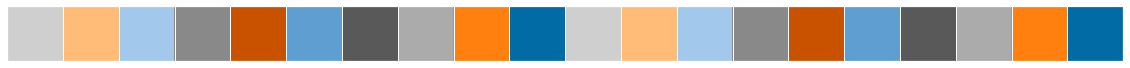

In [ ]:
sns.set(font_scale=2.5)

# using a color-blind friendly palette with 20 colors
color_blind_palette_20 = ['#cfcfcf', '#ffbc79', '#a2c8ec', '#898989', '#c85200',
                          '#5f9ed1', '#595959', '#ababab', '#ff800e', '#006ba4',
                          '#cfcfcf', '#ffbc79', '#a2c8ec', '#898989', '#c85200',
                          '#5f9ed1', '#595959', '#ababab', '#ff800e', '#006ba4']

sns.palplot(color_blind_palette_20)

### Loading data

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

--2021-06-18 08:08:52--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  16.5MB/s    in 0.3s    

2021-06-18 08:08:53 (16.5 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [ ]:
movie_df = pd.read_csv('ml-100k/u.item', sep='|', header=None, encoding='latin1', index_col=False,
                   names=['movie_id',
                          'movie_title',
                          'release_date',
                          'video_release_date',
                          'imdb_url',
                          'unknown',
                          'action',
                          'adventure',
                          'animation',
                          'children',
                          'comedy',
                          'crime',
                          'documentary',
                          'drama',
                          'fantasy',
                          'film_noir',
                          'horror',
                          'musical',
                          'mystery'
                          'romance',
                          'sci_fi',
                          'thriller',
                          'war',
                          'western'])

movie_df.movie_id -= 1 # make this column zero-indexed

In [ ]:
movie_df.head()

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mysteryromance,sci_fi,thriller,war,western
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0


In [ ]:
rating_df = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['user_id','movie_id','rating','timestamp'])
rating_df.user_id -= 1 # make this column zero-indexed
rating_df.movie_id -= 1 # make this column zero-indexed

In [ ]:
rating_df.head()

,user_id,movie_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


## Create agents

In [ ]:
class ReplaySimulator(object):
    '''
    A class to provide base functionality for simulating the replayer method for online algorithms.
    '''

    def __init__(self, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1, random_seed=1):

        np.random.seed(random_seed)
    
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name

        # number of visits to replay/simulate
        self.n_visits = n_visits
        
        # number of runs to average over
        self.n_iterations = n_iterations
    
        # items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        # visitors in the historical reward_history (e.g., from ratings df)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        

    def reset(self):
        # number of times each item has been sampled (previously n_sampled)
        self.n_item_samples = np.zeros(self.n_items)
        
        # fraction of time each item has resulted in a reward (previously movie_clicks)
        self.n_item_rewards = np.zeros(self.n_items)
        
    
    def replay(self):
        
        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
        
            self.reset()
            
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
            
                found_match = False
                while not found_match:
                
                    # choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # if this interaction exists in the history, count it
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                    
                    found_match = reward.shape[0] > 0
                
                reward_value = reward.iloc[0]
                
                self.record_result(visit, item_idx, reward_value)
                
                ## record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                
                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                
                results.append(result)
        
        return results
        
    def select_item(self):
        return np.random.randint(self.n_items)
        
    def record_result(self, visit, item_idx, reward):
    
        self.n_item_samples[item_idx] += 1
        
        alpha = 1./self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])


class ABTestReplayer(ReplaySimulator):
    '''
    A class to provide functionality for simulating the replayer method on an A/B test.
    '''
    
    def __init__(self, n_visits, n_test_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        super(ABTestReplayer, self).__init__(n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations)
        
        # TODO: validate that n_test_visits <= n_visits
    
        self.n_test_visits = n_test_visits
        
        self.is_testing = True
        self.best_item_id = None
        
    def reset(self):
        super(ABTestReplayer, self).reset()
        
        self.is_testing = True
        self.best_item_idx = None
    
    def select_item(self):
        if self.is_testing:
            return super(ABTestReplayer, self).select_item()
        else:
            return self.best_item_idx
            
    def record_result(self, visit, item_idx, reward):
        super(ABTestReplayer, self).record_result(visit, item_idx, reward)
        
        if (visit == self.n_test_visits - 1): # this was the last visit during the testing phase
            
            self.is_testing = False
            self.best_item_idx = np.argmax(self.n_item_rewards)
        

class EpsilonGreedyReplayer(ReplaySimulator):
    '''
    A class to provide functionality for simulating the replayer method on an epsilon-Greedy bandit algorithm.
    '''

    def __init__(self, epsilon, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        super(EpsilonGreedyReplayer, self).__init__(n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations)
    
        # parameter to control exploration vs exploitation
        self.epsilon = epsilon
    
    def select_item(self):
        
        # decide to explore or exploit
        if np.random.uniform() < self.epsilon: # explore
            item_id = super(EpsilonGreedyReplayer, self).select_item()
            
        else: # exploit
            item_id = np.argmax(self.n_item_rewards)
            
        return item_id
    

class ThompsonSamplingReplayer(ReplaySimulator):
    '''
    A class to provide functionality for simulating the replayer method on a Thompson Sampling bandit algorithm.
    '''

    def reset(self):
        self.alphas = np.ones(self.n_items)
        self.betas = np.ones(self.n_items)

    def select_item(self):
    
        samples = [np.random.beta(a,b) for a,b in zip(self.alphas, self.betas)]
        
        return np.argmax(samples)

    def record_result(self, visit, item_idx, reward):
        
        ## update value estimate
        if reward == 1:
            self.alphas[item_idx] += 1
        else:
            self.betas[item_idx] += 1

## Simulation

In [ ]:
# select top-20 most rated movies
n_movies = 20
movie_counts = rating_df.groupby('movie_id')['rating'].count().sort_values(ascending=False)
top_n_movies = rating_df.query('movie_id in {}'.format((movie_counts[:n_movies].index.values.tolist())))

In [ ]:
# add the movie title for ease of access when plotting
# remove the timestamp column because we don't need it
top_n_movies = top_n_movies.merge(movie_df[['movie_id','movie_title']], on='movie_id', how='left') \
                           .drop(columns=['timestamp'])

In [ ]:
top_n_movies.head()

,user_id,movie_id,rating,movie_title
0,199,221,5,Star Trek: First Contact (1996)
1,307,0,4,Toy Story (1995)
2,300,97,4,"Silence of the Lambs, The (1991)"
3,250,99,4,Fargo (1996)
4,24,180,5,Return of the Jedi (1983)


In [ ]:
# remove the year from the title
top_n_movies.movie_title = top_n_movies.movie_title.str.replace('\s+\(.+\)', '').str.strip()

In [ ]:
top_n_movies.movie_title.unique().tolist()

['Star Trek: First Contact',
 'Toy Story',
 'Silence of the Lambs, The',
 'Fargo',
 'Return of the Jedi',
 'Scream',
 'Jerry Maguire',
 'Liar Liar',
 'Raiders of the Lost Ark',
 'Rock, The',
 'Contact',
 'Empire Strikes Back, The',
 'Godfather, The',
 'Twelve Monkeys',
 'Pulp Fiction',
 'English Patient, The',
 'Star Wars',
 'Independence Day',
 'Air Force One',
 'Titanic']

In [ ]:
# create a dictionary between movie_id and movie_title (since the results output doesn't have titles)
movie_titles = top_n_movies.groupby(['movie_id','movie_title']).size().to_frame() \
                                    .reset_index('movie_title').movie_title \
                                    .to_dict()
movie_titles

{0: 'Toy Story',
 6: 'Twelve Monkeys',
 49: 'Star Wars',
 55: 'Pulp Fiction',
 97: 'Silence of the Lambs, The',
 99: 'Fargo',
 116: 'Rock, The',
 120: 'Independence Day',
 126: 'Godfather, The',
 171: 'Empire Strikes Back, The',
 173: 'Raiders of the Lost Ark',
 180: 'Return of the Jedi',
 221: 'Star Trek: First Contact',
 236: 'Jerry Maguire',
 257: 'Contact',
 285: 'English Patient, The',
 287: 'Scream',
 293: 'Liar Liar',
 299: 'Air Force One',
 312: 'Titanic'}

In [ ]:
# Create a dictionary to map these movies to colors for consistency in plots
color_map = dict(zip(top_n_movies.movie_title.sort_values().unique().tolist(), color_blind_palette_20))
color_map

{'Air Force One': '#cfcfcf',
 'Contact': '#ffbc79',
 'Empire Strikes Back, The': '#a2c8ec',
 'English Patient, The': '#898989',
 'Fargo': '#c85200',
 'Godfather, The': '#5f9ed1',
 'Independence Day': '#595959',
 'Jerry Maguire': '#ababab',
 'Liar Liar': '#ff800e',
 'Pulp Fiction': '#006ba4',
 'Raiders of the Lost Ark': '#cfcfcf',
 'Return of the Jedi': '#ffbc79',
 'Rock, The': '#a2c8ec',
 'Scream': '#898989',
 'Silence of the Lambs, The': '#c85200',
 'Star Trek: First Contact': '#5f9ed1',
 'Star Wars': '#595959',
 'Titanic': '#ababab',
 'Toy Story': '#ff800e',
 'Twelve Monkeys': '#006ba4'}

In [ ]:
# What are the actual rating distributions of the top N movies?
rating_counts_by_movie = top_n_movies.groupby(['movie_id','movie_title','rating'], as_index=False).size()
rating_counts_by_movie.head()

,movie_id,movie_title,rating,size
0,0,Toy Story,1,8
1,0,Toy Story,2,27
2,0,Toy Story,3,96
3,0,Toy Story,4,202
4,0,Toy Story,5,119


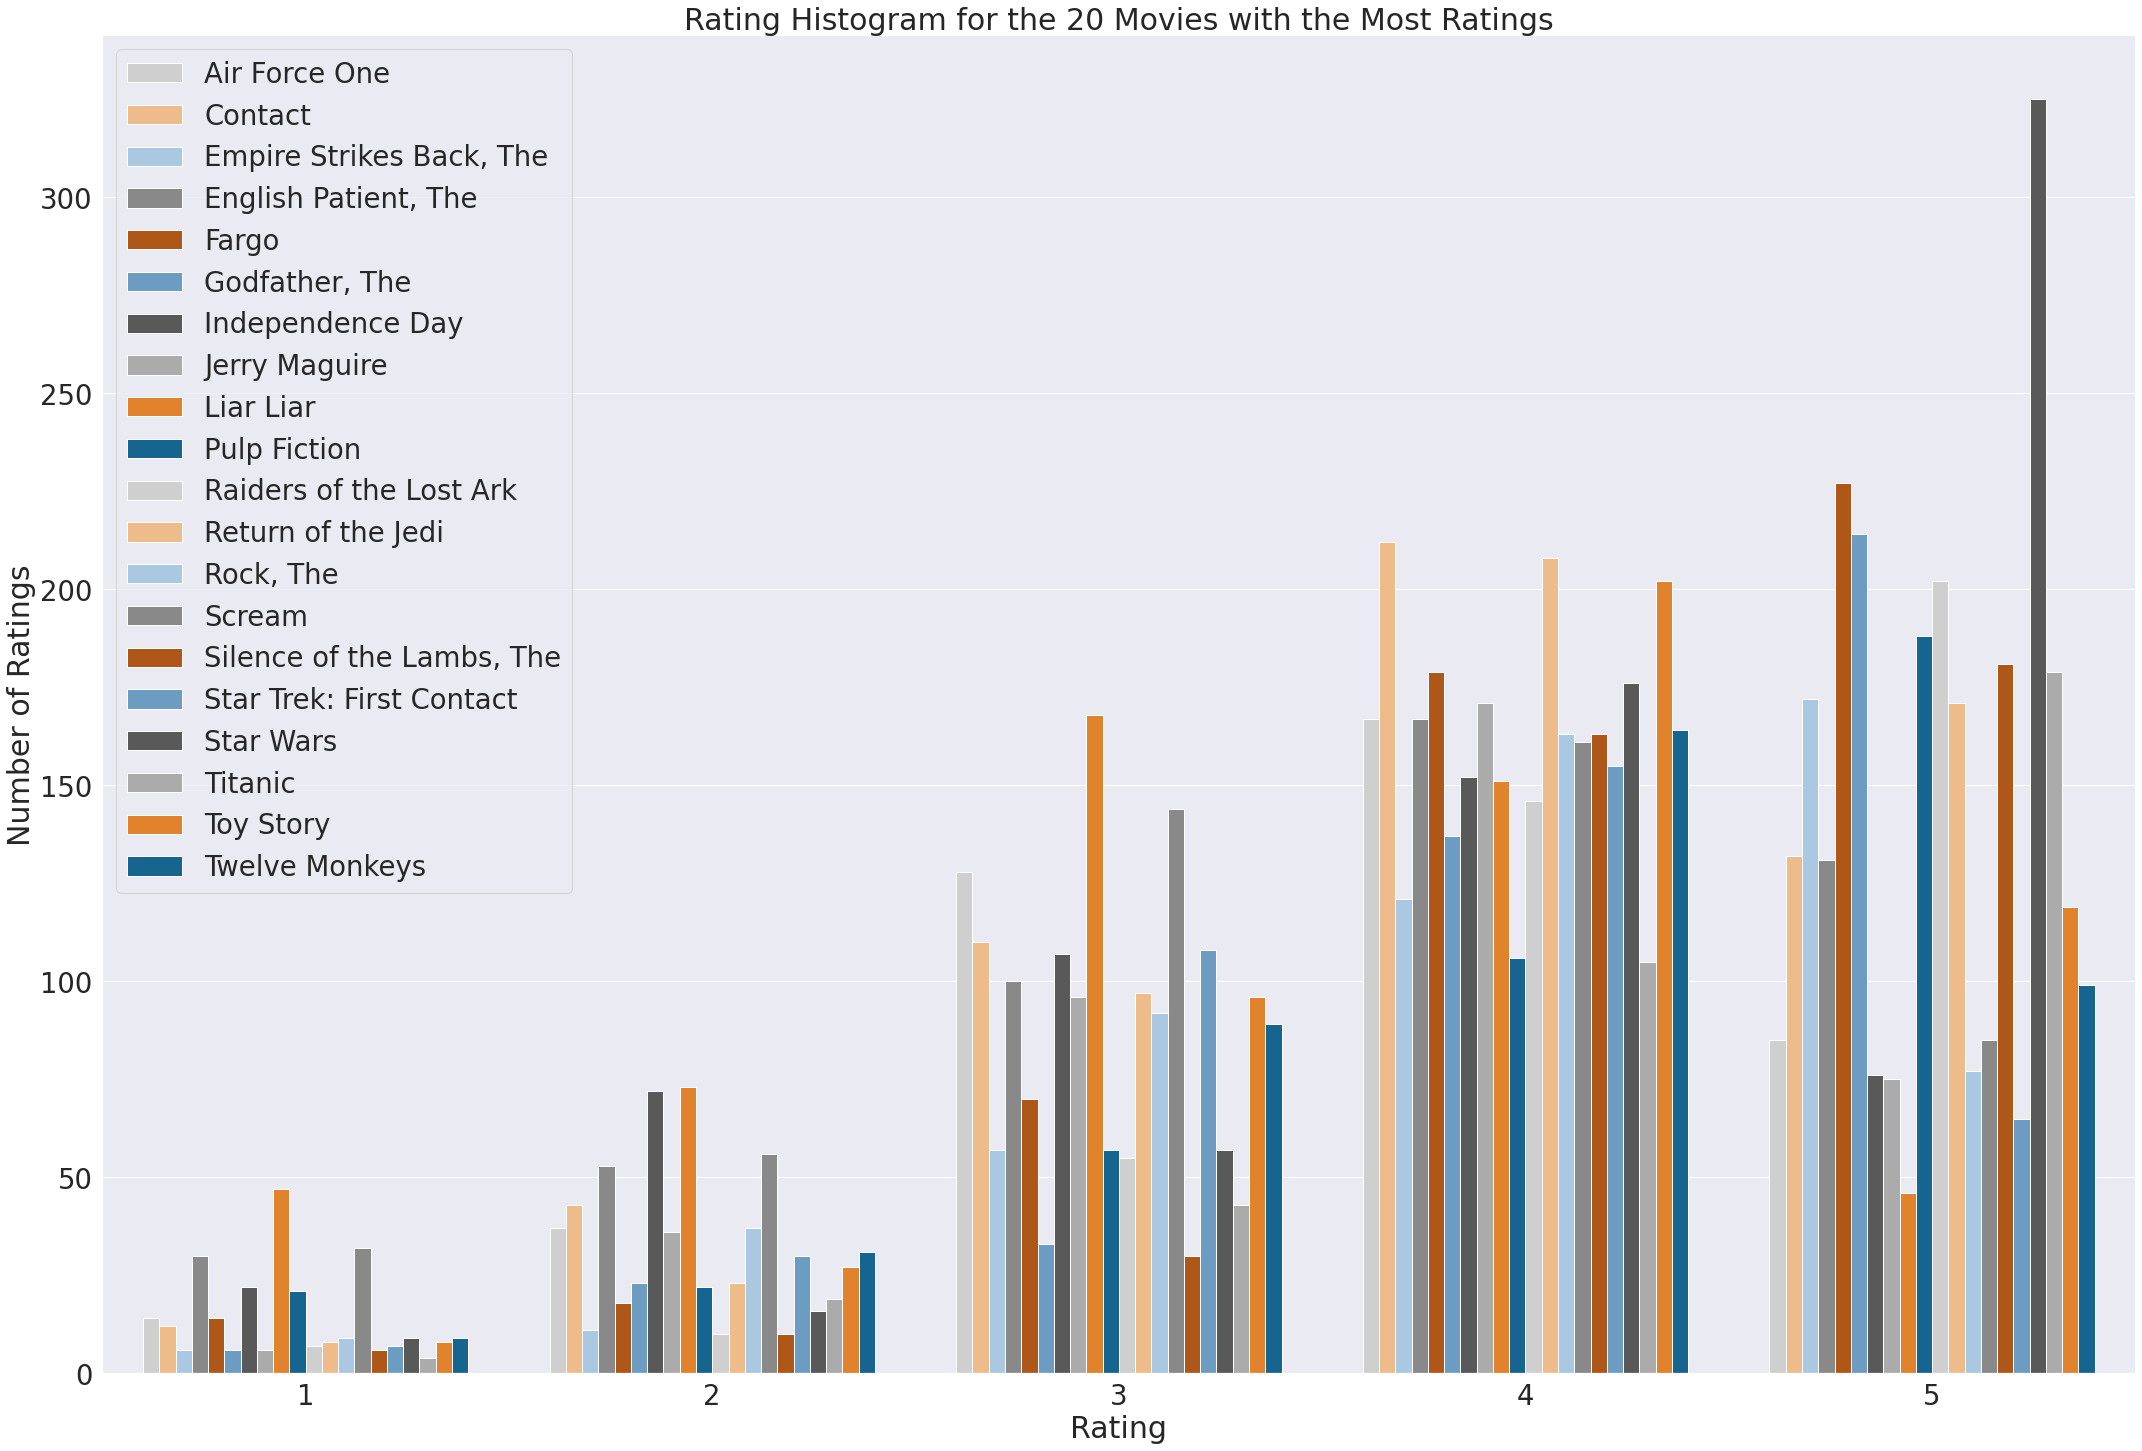

In [ ]:
sns.set_palette(color_blind_palette_20)

rating_v_count_ax = sns.catplot(data=rating_counts_by_movie, x='rating', y='size',
                                   hue='movie_title', hue_order=color_map.keys(),
                                   height=20, aspect=1.5, kind='bar', legend=False)

plt.title('Rating Histogram for the 20 Movies with the Most Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')

plt.legend(title='')

plt.show()

In [ ]:
rating_v_count_ax.savefig('rating_distributions.png', transparent=False)

In [ ]:
# Let's transform the ratings from a discrete range into a binary "like" or "dislike"
# movie ratings above this threshold will be counted as a "like"
reward_threshold = 4
rating_counts_by_movie.eval('liked = rating > @reward_threshold') \
                      .groupby(['movie_title','liked']) \
                      .sum().head()

movie_id  rating  size
movie_title              liked                        
Air Force One            False      1196      10   346
                         True        299       5    85
Contact                  False      1028      10   377
                         True        257       5   132
Empire Strikes Back, The False       684      10   195

In [ ]:
rating_counts_by_movie.eval('liked = rating > @reward_threshold') \
                      .groupby(['movie_title','liked'], as_index=False) \
                      .sum().head()

,movie_title,liked,movie_id,rating,size
0,Air Force One,False,1196,10,346
1,Air Force One,True,299,5,85
2,Contact,False,1028,10,377
3,Contact,True,257,5,132
4,"Empire Strikes Back, The",False,684,10,195


In [ ]:
total_reward_counts = rating_counts_by_movie.eval('liked = rating > @reward_threshold') \
    .groupby(['movie_id','movie_title','liked'])['size'] \
    .sum() \
    .unstack('liked') \
    .reset_index() \
    .rename(columns={False:'disliked', True:'liked'}) \
    .eval('total = disliked + liked') \
    .eval('like_pct = 100 * liked / total')

total_reward_counts.sort_values('like_pct', ascending=False, inplace=True)
total_reward_counts.head(10)

liked,movie_id,movie_title,disliked,liked,total,like_pct
2,49,Star Wars,258,325,583,55.746141
8,126,"Godfather, The",199,214,413,51.815981
19,312,Titanic,171,179,350,51.142857
10,173,Raiders of the Lost Ark,218,202,420,48.095238
3,55,Pulp Fiction,206,188,394,47.715736
9,171,"Empire Strikes Back, The",195,172,367,46.866485
4,97,"Silence of the Lambs, The",209,181,390,46.410256
5,99,Fargo,281,227,508,44.685039
11,180,Return of the Jedi,336,171,507,33.727811
15,285,"English Patient, The",350,131,481,27.234927


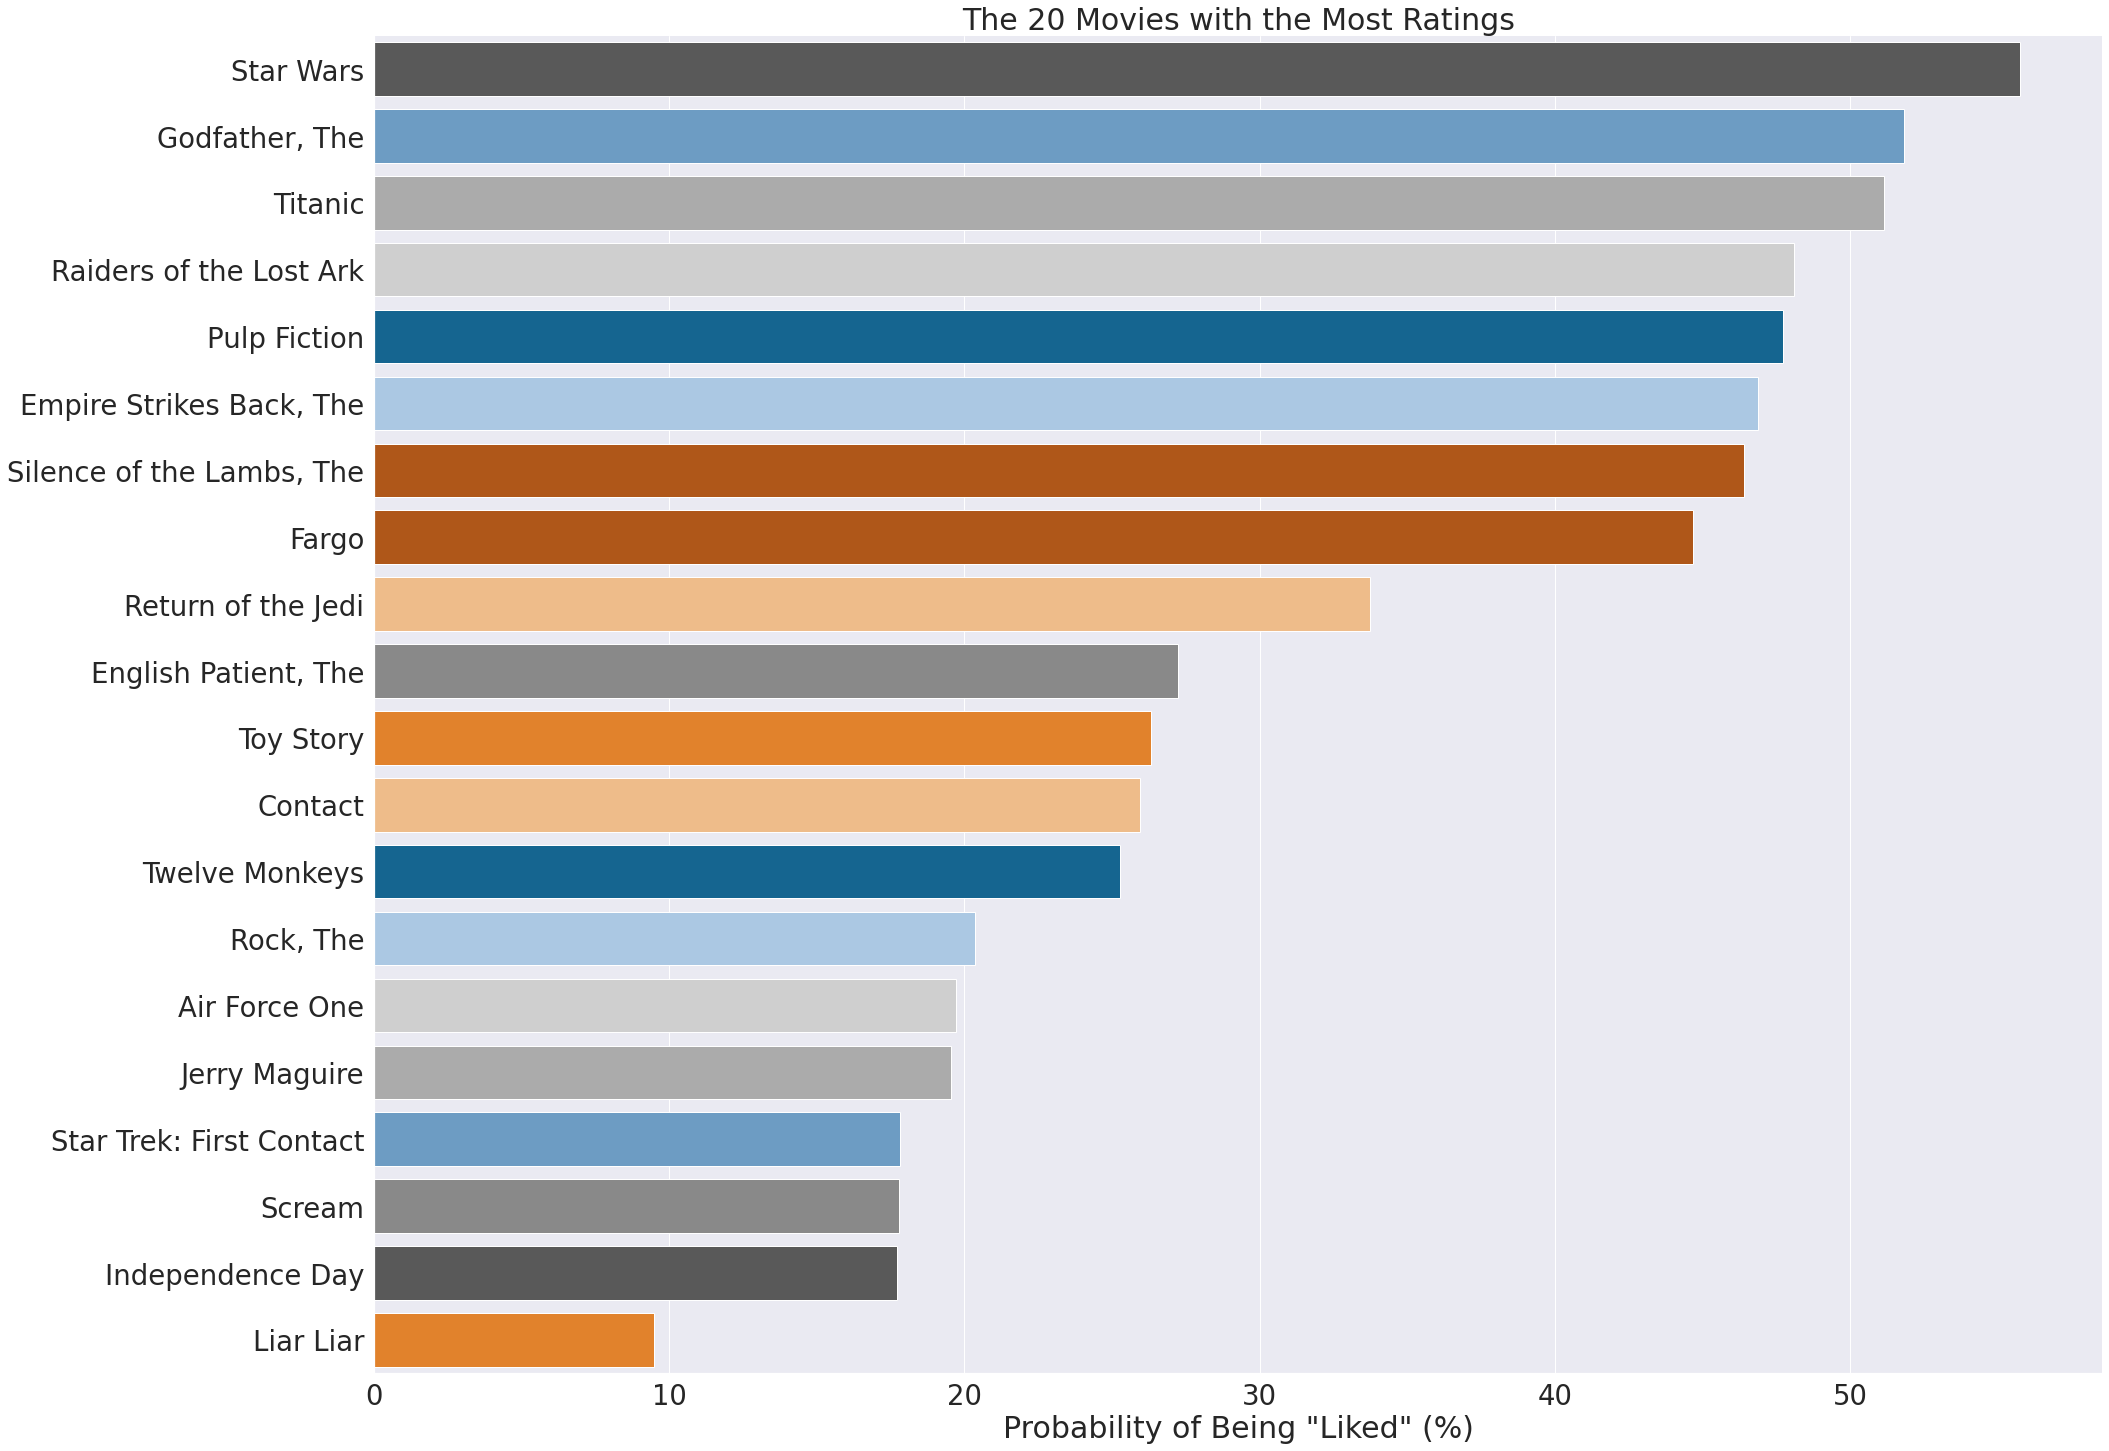

In [ ]:
like_probability_ax = sns.catplot(height=20, aspect=1.5, x='like_pct', y='movie_title', kind='bar',
                                     palette=total_reward_counts['movie_title'].apply(lambda x: color_map[x]),
                                     data=total_reward_counts)

plt.title('The 20 Movies with the Most Ratings')
like_probability_ax.set_axis_labels('Probability of Being "Liked" (%)','')

plt.show()

In [ ]:
like_probability_ax.savefig('like_probabilities.png', transparent=False)

In [ ]:
# Translate ratings into a binary reward value
reward_threshold = 4
rating_df['reward'] = rating_df.eval('rating > @reward_threshold').astype(int)
rating_df.head()

,user_id,movie_id,rating,timestamp,reward
0,195,241,3,881250949,0
1,185,301,3,891717742,0
2,21,376,1,878887116,0
3,243,50,2,880606923,0
4,165,345,1,886397596,0


## Running the simulation

In [ ]:
# Set the parameters for the simulations
n_visits = 50 # 20000 for more realistic results, will take time time to run
n_iterations = 10 #20

reward_history = rating_df[:1000]
item_col_name = 'movie_id'
visitor_col_name = 'user_id'
reward_col_name = 'reward'

## A/B test simulation

In [ ]:
n_test_visits = 30 #1000
ab_results_1 = ABTestReplayer(n_visits, n_test_visits, reward_history,
                               item_col_name, visitor_col_name, reward_col_name,
                               n_iterations=n_iterations).replay()

ab_results_1_df = pd.DataFrame(ab_results_1)
ab_results_1_df.head()

100%|██████████| 10/10 [02:54<00:00, 17.40s/it]


,iteration,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0,1060,191,0,0,0.000000
1,0,1,233,159,1,1,0.500000
2,0,2,475,206,0,1,0.333333
3,0,3,185,12,0,1,0.250000
4,0,4,47,71,0,1,0.200000


In [ ]:
# save the output
ab_results_1_df.to_csv('ab_results_1.csv')

In [ ]:
n_test_visits = 50 #5000
ab_results_2 = ABTestReplayer(n_visits, n_test_visits, reward_history,
                               item_col_name, visitor_col_name, reward_col_name,
                               n_iterations=n_iterations).replay()

ab_results_2_df = pd.DataFrame(ab_results_2)
ab_results_2_df.head()

100%|██████████| 10/10 [03:24<00:00, 20.40s/it]


,iteration,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0,1060,191,0,0,0.000000
1,0,1,233,159,1,1,0.500000
2,0,2,475,206,0,1,0.333333
3,0,3,185,12,0,1,0.250000
4,0,4,47,71,0,1,0.200000


In [ ]:
# save the output
ab_results_2_df.to_csv('ab_results_2.csv')

### ϵ-Greedy simulation

In [ ]:
epsilon = 0.05
epsilon_05_results = EpsilonGreedyReplayer(epsilon, n_visits, reward_history,
                                           item_col_name, visitor_col_name, reward_col_name,
                                           n_iterations=n_iterations).replay()

epsilon_05_results_df = pd.DataFrame(epsilon_05_results)
epsilon_05_results_df.head()

100%|██████████| 10/10 [02:18<00:00, 13.84s/it]


,iteration,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0,241,62,0,0,0.00
1,0,1,241,62,0,0,0.00
2,0,2,241,62,0,0,0.00
3,0,3,241,225,1,1,0.25
4,0,4,241,195,0,1,0.20


In [ ]:
# save the output
epsilon_05_results_df.to_csv('epsilon_greedy_05.csv')

In [ ]:
epsilon = 0.10
epsilon_10_results = EpsilonGreedyReplayer(epsilon, n_visits, reward_history,
                                           item_col_name, visitor_col_name, reward_col_name,
                                           n_iterations=n_iterations).replay()

epsilon_10_results_df = pd.DataFrame(epsilon_10_results)
epsilon_10_results_df.head()

100%|██████████| 10/10 [02:13<00:00, 13.39s/it]


,iteration,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0,241,195,0,0,0.0
1,0,1,241,62,0,0,0.0
2,0,2,241,62,0,0,0.0
3,0,3,241,62,0,0,0.0
4,0,4,241,195,0,0,0.0


In [ ]:
# save the output
epsilon_10_results_df.to_csv('epsilon_greedy_10.csv')

### Thompson sampling simulation

In [ ]:
thompson_results = ThompsonSamplingReplayer(n_visits, reward_history,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()

thompson_results_df = pd.DataFrame(thompson_results)
thompson_results_df.head()

100%|██████████| 10/10 [04:33<00:00, 27.33s/it]


,iteration,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0,273,193,0,0,0.0
1,0,1,863,12,0,0,0.0
2,0,2,237,249,0,0,0.0
3,0,3,477,124,0,0,0.0
4,0,4,871,32,0,0,0.0


In [ ]:
# save the output
thompson_results_df.to_csv('thompson_sampling.csv')

## Result analysis

### Thompson sampling output

In [ ]:
thompson_results_df.query('iteration == 0')

,iteration,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0,273,193,0,0,0.000000
1,0,1,863,12,0,0,0.000000
2,0,2,237,249,0,0,0.000000
3,0,3,477,124,0,0,0.000000
4,0,4,871,32,0,0,0.000000
5,0,5,1017,298,0,0,0.000000
6,0,6,303,56,1,1,0.142857
7,0,7,257,206,0,1,0.125000
8,0,8,24,269,1,2,0.222222
9,0,9,126,108,0,2,0.200000


In [ ]:
thompson_results_df.query('iteration == 0') \
                                .eval('selected = 1') \
                                .pivot(index='visit', columns='item_id', values='selected') \
                                .fillna(0) \
                                .cumsum(axis=0) \
                                .reset_index() \
                                .rename(columns=movie_titles).shape

(50, 51)

In [ ]:
# Let's visualize the Thompson Sampling output for a single run
# We'll look at each movie's percentage of the total recommendations as the simulation progressed

# create a dataframe with running totals of how many times each recommendation was taken
thompson_running_ttl = thompson_results_df.query('iteration == 0') \
                                .eval('selected = 1') \
                                .pivot(index='visit', columns='item_id', values='selected') \
                                .fillna(0) \
                                .cumsum(axis=0) \
                                .reset_index() \
                                .rename(columns=movie_titles)

# scale the value by the visit number to get turn the running total into a percentage
thompson_running_ttl.iloc[:,1:] = thompson_running_ttl.iloc[:,1:].div((thompson_running_ttl.visit + 1)/100, axis=0)

thompson_running_ttl.head()

item_id,visit,24,32,48,76,"Godfather, The",130,160,176,185,Star Trek: First Contact,231,237,Contact,273,279,303,304,316,343,356,365,380,384,426,442,477,500,506,507,563,602,647,653,662,720,724,738,745,750,773,786,863,871,900,918,1014,1017,1027,1048,1287
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,50.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.333333,0.0,33.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.000000,0.0,25.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.000000,0.0,20.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.000000,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


KeyError: ignored

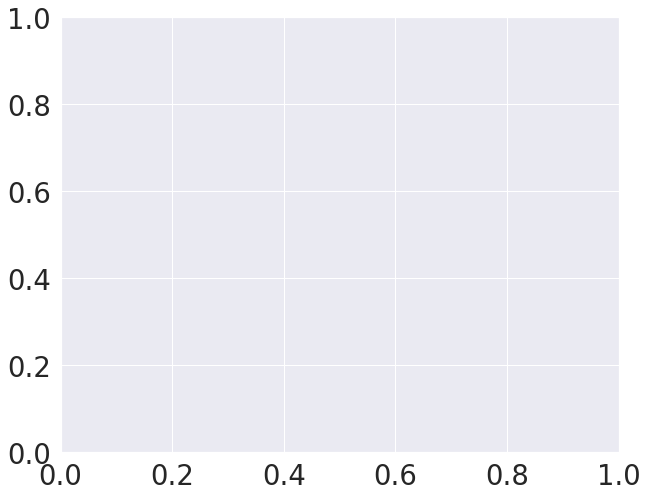

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ax.stackplot(thompson_running_ttl.visit,
             thompson_running_ttl.iloc[:,1:21].T,
             labels=thompson_running_ttl.iloc[:,1:21].columns.values.tolist(),
             colors=[color_map[x] for x in thompson_running_ttl.iloc[:,1:].columns.values]
            )

ax.set_xlim(0,1000)
ax.set_xticks(range(0, 1100, 250))

ax.set_title('Thompson Sampling Algorithm')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recommendations')

lgd = plt.legend(bbox_to_anchor=(1.02, 0.15), loc=2, borderaxespad=0., labelspacing=-2.3)

ax.set_facecolor('w')

plt.tight_layout()
plt.show()

In [ ]:
fig.savefig('bandit_results.png', transparent=False, bbox_extra_artists=(lgd,), bbox_inches='tight')

### Average the results across all runs

In [ ]:
ab_1k_avg_results_df = ab_1k_results_df.groupby('visit', as_index=False).mean()

ab_5k_avg_results_df = ab_5k_results_df.groupby('visit', as_index=False).mean()

epsilon_05_avg_results_df = epsilon_05_results_df.groupby('visit', as_index=False).mean()

epsilon_10_avg_results_df = epsilon_10_results_df.groupby('visit', as_index=False).mean()

thompson_avg_results_df = thompson_results_df.groupby('visit', as_index=False).mean()

### Compare the results

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

for (avg_results_df, style) in [(ab_1k_avg_results_df, 'r-'),
                                (ab_5k_avg_results_df, 'r--'),
                                (epsilon_05_avg_results_df, 'b-'),
                                (epsilon_10_avg_results_df, 'b--'),
                                (thompson_avg_results_df, 'tab:brown')]:
    
    ax.plot(avg_results_df.visit, avg_results_df.fraction_relevant, style, linewidth=3.5)

# add a line for the optimal value -- 0.5575 for Star Wars
ax.axhline(y=0.5575, color='k', linestyle=':', linewidth=2.5)

ax.set_title('Percentage of Liked Recommendations')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recs Liked')

ax.set_xticks(range(0,22000,5000))
ax.set_ylim(0.2, 0.6)
ax.set_yticks(np.arange(0.2, 0.7, 0.1))

# rescale the y-axis tick labels to show them as a percentage
ax.set_yticklabels((ax.get_yticks()*100).astype(int))

ax.legend(['A/B Test (1k Recs)',
           'A/B Test (5k Recs)',
           '$\epsilon$ = 0.05',
           '$\epsilon$ = 0.10',
           'Thompson Sampling',
           'Optimal (Star Wars)'
          ],
          loc='lower right'
         )

plt.tight_layout()
plt.show()

In [ ]:
fig.savefig('pct_liked_recs.png', transparent=False)